In [2]:
pip install wavio

In [3]:
# General
import os
import time
from random import shuffle

# Math
import numpy as np 
# Data management
import pandas as pd
# Data Visualizatoin
import matplotlib.pyplot as plt
# %matplotlib inline

# Machine Learning
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation


import wavio
import librosa
import librosa.display

In [4]:
!mkdir respiratory_sound_database

In [5]:
!unzip /content/drive/MyDrive/Respiratory_Sound_Database.zip

Archive:  /content/drive/MyDrive/Respiratory_Sound_Database.zip
   creating: Respiratory_Sound_Database/audio_and_txt_files/
  inflating: Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Al_sc_Meditron.txt  
  inflating: Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Al_sc_Meditron.wav  
  inflating: Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Pr_sc_Meditron.txt  
  inflating: Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Pr_sc_Meditron.wav  
  inflating: Respiratory_Sound_Database/audio_and_txt_files/102_1b1_Ar_sc_Meditron.txt  
  inflating: Respiratory_Sound_Database/audio_and_txt_files/102_1b1_Ar_sc_Meditron.wav  
  inflating: Respiratory_Sound_Database/audio_and_txt_files/103_2b2_Ar_mc_LittC2SE.txt  
  inflating: Respiratory_Sound_Database/audio_and_txt_files/103_2b2_Ar_mc_LittC2SE.wav  
  inflating: Respiratory_Sound_Database/audio_and_txt_files/104_1b1_Al_sc_Litt3200.txt  
  inflating: Respiratory_Sound_Database/audio_and_txt_files/104_1b1_Al_sc_

In [6]:
!mv "/content/demographic_info.txt" "/content/respiratory_sound_database"

In [7]:
data_dir = '/content/respiratory_sound_database'

demogr_fname = '/content/respiratory_sound_database/demographic_info.txt'
demogrCol_strLst = ['Patient number', 'Age', 'Sex' , 'Adult BMI (kg/m2)', 'Child Weight (kg)' , 'Child Height (cm)']
demogr_df = pd.read_csv(
    demogr_fname, 
    names = demogrCol_strLst,
    delimiter = ' ',
)

demogr_fname = '/content/Respiratory_Sound_Database/patient_diagnosis.csv'
diagnosisCol_strLst = ['Patient number', 'Diagnosis']
diagnosis_df = pd.read_csv(
    demogr_fname,
    names = diagnosisCol_strLst,
)

data_dname = '/content/Respiratory_Sound_Database/audio_and_txt_files'
records_idLst = [s.split('.')[0] for s in os.listdir(path = data_dname) if '.txt' in s]

print("# Of recordings: %d"%(len(records_idLst)))

# Of recordings: 920


In [8]:
def loadData(record_id, dry = False):
    
    data_fname = record_id + '.wav'
    annotation_fname = record_id + '.txt'
    
    if not dry:
        wave_data = wavio.read(data_dname+'/'+data_fname)
        waveform_np = wave_data.data.astype(float).flatten()
        waveWidth_int= wave_data.sampwidth

        # Get the info of the wavefile
        fs = wave_data.rate # Sampling frequency
        N = waveform_np.shape[0]
        
    else:
        waveform_np = None
        fs = float('nan')
        N = float('nan')
    Ts = 1.0 / fs;
    AT = Ts * N    

    tokens_strLst = record_id.split('_') + [fs, N, AT, Ts]
    
    infoLabels_strLst = ['Patient number', 'Recording index', 'Chest location','Acquisition mode','Recording equipment', 'fs', 'N', 'AT', 'Ts']
    recordInfo_dict = dict(zip(infoLabels_strLst,tokens_strLst))
    
    dataCols_strLst = ['Start', 'End', 'Crackles', 'Wheezes']
    recAnnotations_df = pd.read_csv(
        os.path.join(data_dname, annotation_fname), 
        names = dataCols_strLst,
        delimiter= '\t'
    )
    
    return (waveform_np, recordInfo_dict, recAnnotations_df)

(waveform_np, recordInfo_dict, recAnnotations_df) = loadData(records_idLst[0], 0)
_, recordInfo_dict, recAnnotations_df = loadData(records_idLst[0], 1)

In [9]:
# Class to time the execution blocks
class Timer():
    # Static variable for verbosity
    quiet = False
    
    # Init the class
    def __init__(self, str): 
        # print('init method called') 
        self.str = str
        
    # Enter the context
    def __enter__(self):
        # print('enter method called') 
        self.tick = time.time()
        return self
    
    # Leave the context
    def __exit__(self, exc_type, exc_value, exc_traceback): 
        if not Timer.quiet:
            print("%s: \t%.3f s"%(self.str, time.time() - self.tick))

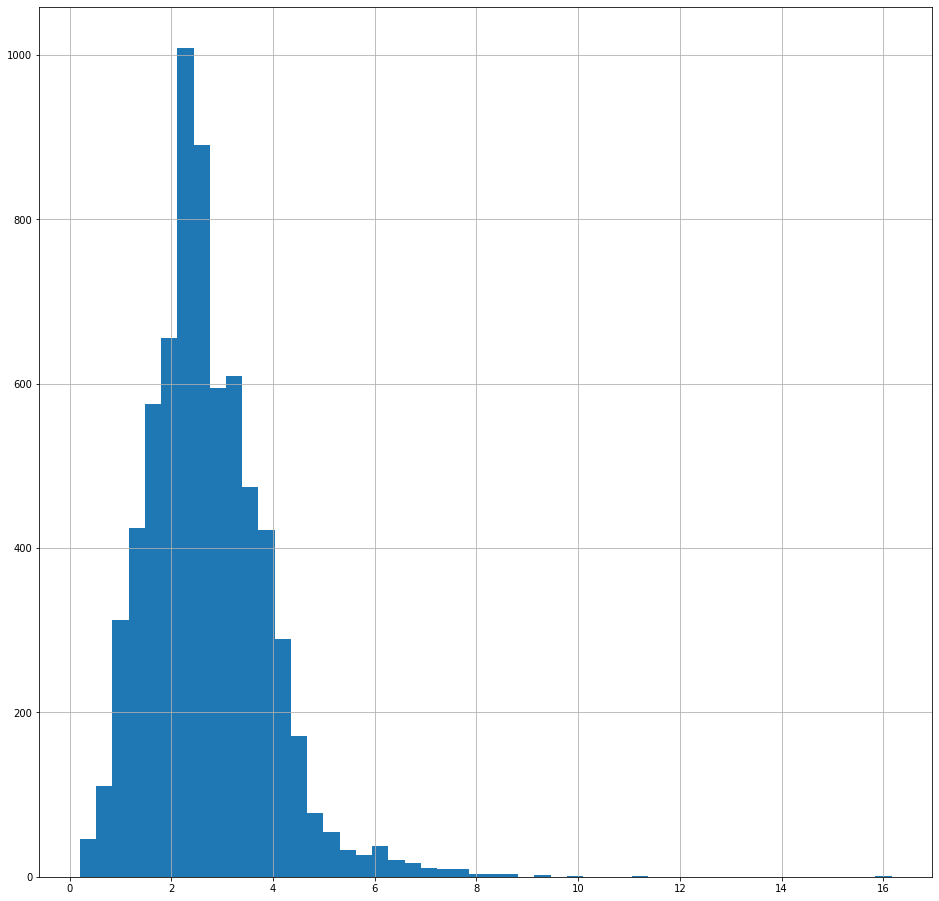

In [10]:
# Distribution of respiratory cycle lengths

respDuration_ser = pd.Series([],dtype='float64')
for record_id in records_idLst:
    _, recordInfo_dict, recAnnotations_df = loadData(record_id, dry = True)
    respDuration_ser = respDuration_ser.append(recAnnotations_df['End'] - recAnnotations_df['Start'])

plt.figure(figsize=(16,16))
respDuration_ser.hist(bins=50)

/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


(431, 24)
[ -3.1562586   -6.93581433  -1.09504857  -1.93189636 -15.881873
 -11.40576428  -7.49841248  -8.48212566  -5.05972086  -5.89395887
  -5.6067162   -6.12791685  -5.82118933  -5.87428951  -5.01659241
  -5.2831059   -4.89372115  -5.23137595  -4.0672694   -3.07492203
  -2.9676304   -2.97084577  -3.21692766  -3.03764836]
[-7.83080741e-17 -2.64804935e-16  8.65510293e-17  7.41865965e-17
 -4.45531727e-15 -1.52494671e-15 -1.54143262e-15 -1.32711578e-15
 -4.12147759e-17  1.81345014e-16 -3.66811505e-16 -4.69848445e-16
 -3.04989341e-16  9.52061322e-16 -1.15401372e-16 -6.26464593e-16
  6.42950503e-16 -4.12147759e-17 -1.48373193e-16  1.15401372e-16
 -1.31887283e-16  0.00000000e+00 -8.24295517e-18 -2.14316834e-16]
[3.26688226 2.39790154 2.9539318  5.8096594  4.54525429 2.49622782
 2.17656347 2.27732303 2.33211977 2.29224921 2.59230864 2.47190415
 2.54436017 2.70454846 3.45322665 3.16354001 3.2483355  2.94606755
 3.86711845 2.6872645  2.66629307 2.5121103  3.17801922 2.7110774 ]
[1. 1. 1. 1. 1

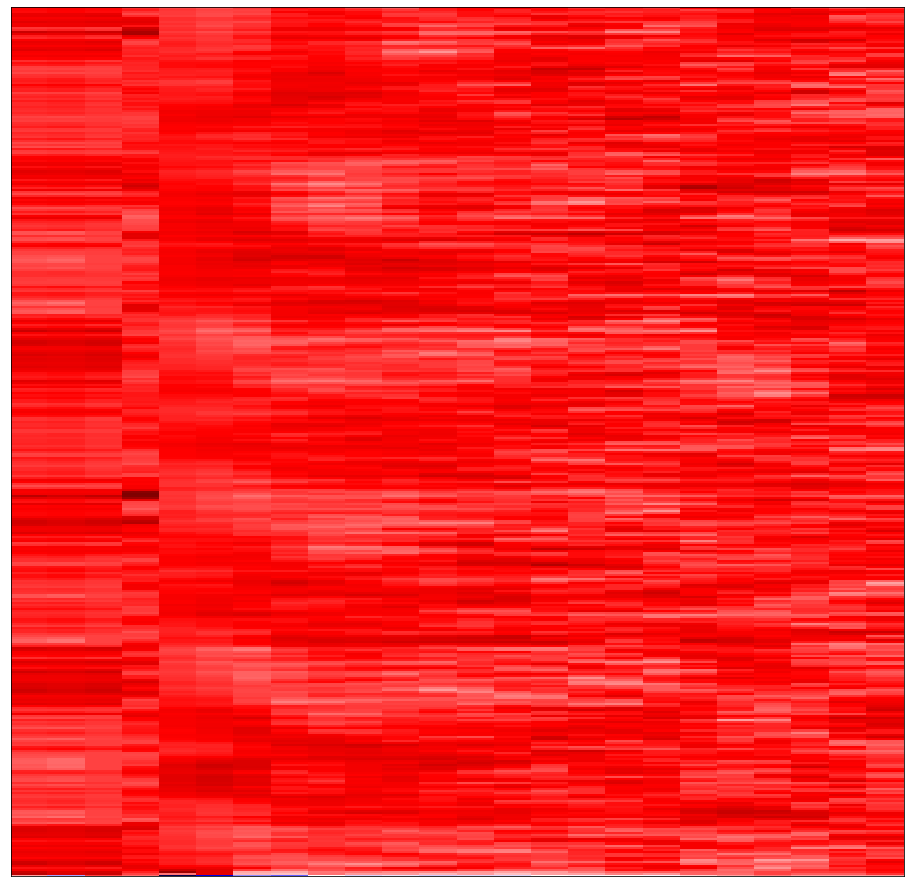

In [11]:
# Feature extraction

# Parameters
frameLength_int = 2**13
frameHop_int = 2**11

# Derivative values
frameOvelap_int = frameLength_int - frameHop_int

def extractFeatures(waveform_np, recordInfo_dict, dry=False):
    
    if dry:
        # Extract the spectrum from the waveform
        spectrum_np = librosa.core.stft(
           waveform_np, 
           n_fft=frameLength_int, 
           hop_length=frameHop_int, 
           win_length=frameLength_int, 
        )
        spectrumMag_np = np.abs(spectrum_np)
        spectrumN_int = spectrumMag_np.shape[1]
        spectrumTime_np = np.linspace(0,recordInfo_dict['AT'],spectrumN_int)
    else:
        # Chroma Frequencies
        chroma_np = librosa.feature.chroma_stft(
            waveform_np, 
            sr=recordInfo_dict['fs'],
            n_fft=frameLength_int, 
            hop_length=frameHop_int, 
            win_length=frameLength_int, 
        )

        # Spectral Centroid
        spectralCentroid_np = librosa.feature.spectral_centroid(
            waveform_np,
            sr=recordInfo_dict['fs'],
            n_fft=frameLength_int, 
            hop_length=frameHop_int, 
            win_length=frameLength_int, 
        )

        # Spectral Bandwidth
        spectralBandwidth_np = librosa.feature.spectral_bandwidth(
            waveform_np, 
            sr=recordInfo_dict['fs'],
            n_fft=frameLength_int, 
            hop_length=frameHop_int, 
            win_length=frameLength_int, 
        )

        # Spectral Roll-off
        spectralRolloff_np = librosa.feature.spectral_rolloff(
            waveform_np,
            sr=recordInfo_dict['fs'],
            n_fft=frameLength_int, 
            hop_length=frameHop_int, 
            win_length=frameLength_int, 
        )

        # Zero Crossing Rate
        spectralZeroCrossing_zp = librosa.feature.zero_crossing_rate(
            waveform_np,
            hop_length=frameHop_int, 
            frame_length=frameLength_int, 
        )

        # Mel Cepstral Coeffs (MFCC)
        mfcc_np = librosa.feature.mfcc(
            waveform_np,
            sr=recordInfo_dict['fs'],
            n_fft=frameLength_int, 
            hop_length=frameHop_int, 
            win_length=frameLength_int, 
        )

    features_np = np.concatenate((
#        spectrumMag_np,
        spectralCentroid_np,
        spectralBandwidth_np,
        spectralRolloff_np,
        spectralZeroCrossing_zp,
#        chroma_np,
        mfcc_np,
    )).T
    
    
    
    scaler = preprocessing.StandardScaler()
    #scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    features_np = scaler.fit_transform(features_np)
        
    return features_np


(waveform_np, recordInfo_dict, recAnnotations_df) = loadData(records_idLst[0])
features_np = extractFeatures(waveform_np, recordInfo_dict)

plt.figure(figsize=(16,16))
librosa.display.specshow(
    #   librosa.amplitude_to_db(features_np, ref=np.max),
    features_np,
    #   x_coords=spectrumTime_np,
    #y_axis='time',
    #x_axis='log',
    cmap = 'seismic'
)

print(features_np.shape)
print(features_np.min(axis=0))
print(features_np.mean(axis=0))
print(features_np.max(axis=0))
print(features_np.std(axis=0))

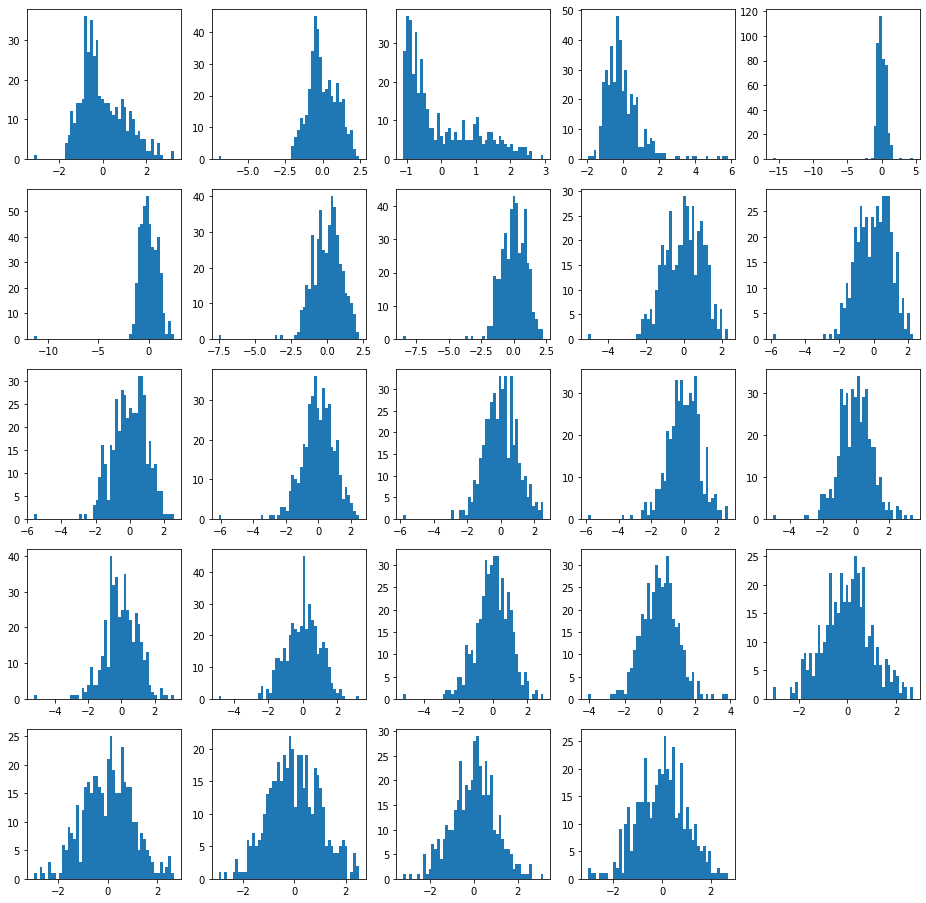

In [12]:
M = features_np.shape[1]
rows = np.ceil(np.sqrt(M))
cols = np.ceil(np.sqrt(M))
plt.figure(figsize=(16,16))


for i in range(M):
    plt.subplot(rows,cols,i+1)
    #plt.plot(t_np,features_np[:,i])
    plt.hist(features_np[:,i], bins=50)
    

In [13]:
# Display a representative spectrum

spectrum_np = librosa.core.stft(
   waveform_np, 
   n_fft=frameLength_int, 
   hop_length=frameHop_int, 
   win_length=frameLength_int, 
)
spectrumMagLog_np = np.log(np.abs(spectrum_np))
spectrumN_int = spectrumMagLog_np.shape[1]
spectrumTime_np = np.linspace(0,recordInfo_dict['AT'],spectrumN_int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


(4097, 431)


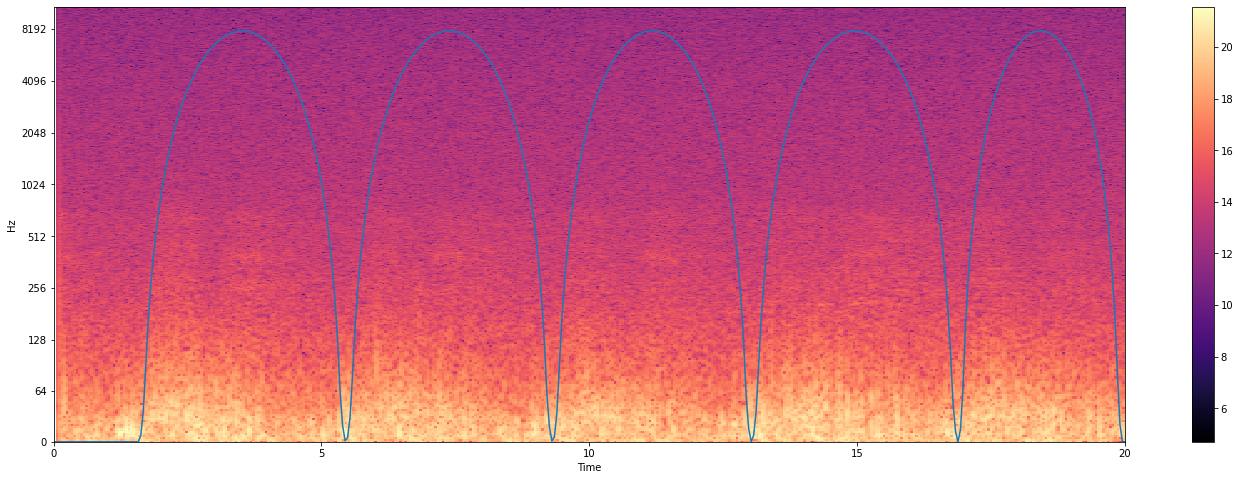

In [14]:
# Convert the annotations to a usable Y vector
# TODO: Perhaps we can use a complex periodic signal i.e. 2 output vectors

def annotations2Y(recAnnotations_df, recordInfo_dict):

    # Variables
    t = spectrumTime_np
    Y = np.zeros(t.shape[0])
    lag_f = 0
    
    for row in recAnnotations_df.itertuples():
        start_f = row.Start
        stop_f = row.End
        duration_f = stop_f - start_f
        mask_b = np.logical_and(t >= start_f, t < stop_f)
        x = 0.5 - np.cos(2*np.pi*(t-stop_f)/duration_f)/2
        
        Y[mask_b] = x[mask_b]
        
    return t,Y

t_np, Y_np = annotations2Y(recAnnotations_df, recordInfo_dict)

plt.figure(figsize=(24,8))
librosa.display.specshow(
    spectrumMagLog_np,
    x_coords=spectrumTime_np,
    y_axis='log',
    x_axis='time',
)
# Draw the Y over the spectrogram
plt.plot(t_np,Y_np*8000)
plt.colorbar()

print(spectrumMagLog_np.shape)

(431, 24)
(431,)


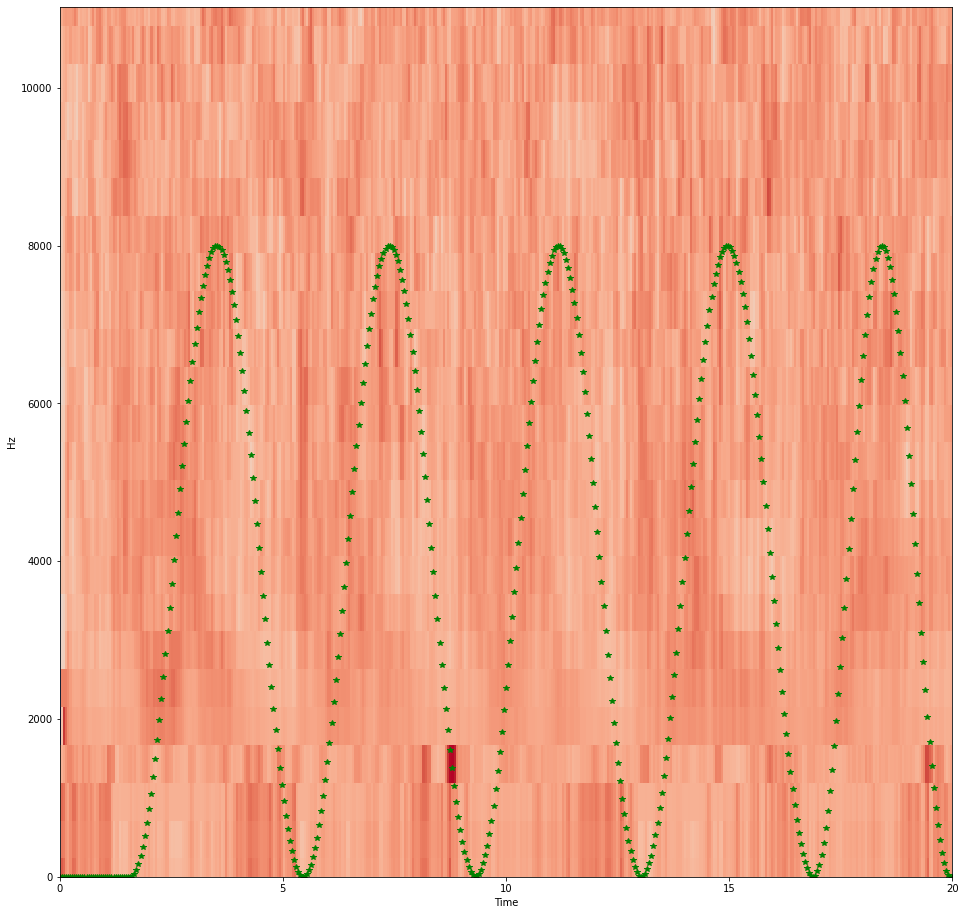

In [15]:
# Temp, this code block is for testing purposes
# Ignore

spectrum_np = librosa.core.stft(
    waveform_np, 
    n_fft=frameLength_int, 
    hop_length=frameHop_int, 
    win_length=frameLength_int, 
)
spectrumMag_np = np.abs(spectrum_np)
spectrumN_int = spectrumMag_np.shape[1]
spectrumTime_np = np.linspace(0,recordInfo_dict['AT'],spectrumN_int)

#plt.figure(figsize=(16,16))
#librosa.display.specshow(
#    librosa.amplitude_to_db(spectrumMag_np, ref=np.max),
#    #spectrumMag_np,
#    x_coords=spectrumTime_np,
#    x_axis='time',
#    y_axis='log',
#    cmap = 'seismic'
#)



plt.figure(figsize=(16,16))
librosa.display.specshow(
    #librosa.amplitude_to_db(spectrumMag_np, ref=np.max),
    features_np.T,
    x_coords=spectrumTime_np,
    x_axis='time',
#    y_axis='log',
    y_axis='hz',
#    cmap = 'seismic'
)
plt.plot(t_np,Y_np*8000,'g*')
print(features_np.shape)
print(spectrumTime_np.shape)

In [16]:
# Concatenate the files into a big dataset

def generateDataset(records_idLst):
    
    records_cnt = len(records_idLst)
    
    # This function takes time so lets do some reporting
    print("Generating a dataset of %d records"%(records_cnt))
    
    datasetX_np = None
    datasetY_np = None
    for index_int, record_id in enumerate(records_idLst):
        
        # Load the file
        (waveform_np, recordInfo_dict, recAnnotations_df) = loadData(records_idLst[0])

        # Extract the features
        features_np = extractFeatures(waveform_np, recordInfo_dict, )

        # Extract the target
        t_np, Y_np = annotations2Y(recAnnotations_df, recordInfo_dict)

        if datasetX_np is None:
            datasetX_np = features_np
            datasetY_np = Y_np
        else:
            datasetX_np = np.append(datasetX_np, features_np, axis=0)
            datasetY_np = np.append(datasetY_np, Y_np)
        print("Loading: %5.2f%%\t%s"%(100.0 * (index_int + 1) / records_cnt, record_id), end="\r")
        
    print("")
    print(datasetX_np.shape)
    print(datasetY_np.shape)
    return datasetX_np, datasetY_np

In [17]:
# Parameters
testN_cnt = 10

# Randomize the dataset order
shuffle(records_idLst)
# Split the training and test datasets
trainRecords_idLst = records_idLst[testN_cnt:]
testRecords_idLst = records_idLst[:testN_cnt]

In [18]:
# Evaluate and visualize the model results

def evaluateModel(model):
    
    trainR2_f = model.score(trainX_np, trainY_np)
    testR2_f = model.score(testX_np, testY_np)
    print("Train R2: %8.5f\t Test R2: %8.5f\t (%5.2f)"%(trainR2_f,testR2_f,testR2_f/trainR2_f))

    trainResult_np = model.predict(trainX_np)
    testResult_np = model.predict(testX_np)
    visualResult_np = model.predict(visualX_np)

    trainMAE_f = metrics.mean_absolute_error(trainY_np, trainResult_np)
    testMAE_f = metrics.mean_absolute_error(testY_np, testResult_np)
    print("Train MAE: %8.5f\t Test MAE: %8.5f\t (%5.2f)"%(trainMAE_f,testMAE_f,testMAE_f/trainMAE_f))

    # Visualize the test performance
    visualX_np, visualY_np

    plt.figure(figsize=(24,10))
    
    plt.subplot(211)
    plt.plot(trainY_np[:visualN_cnt],'g')
    plt.plot(trainResult_np[:visualN_cnt],'b.')
    plt.title('Training Set fit')
    
    plt.subplot(212)
    plt.plot(visualY_np,'g')
    plt.plot(visualResult_np,'b.')
    plt.title('Test Set fit')

In [19]:
# Create the training dataset

with Timer("Training set generation:"):
    trainX_np, trainY_np = generateDataset(trainRecords_idLst)
print("Training dataset consists of %d records"%(len(trainRecords_idLst)))

Generating a dataset of 910 records
Loading: 100.00%	156_2b3_Ar_mc_AKGC417L
(392210, 24)
(392210,)
Training set generation:: 	629.257 s
Training dataset consists of 910 records


In [20]:
# Create the test set

testX_np, testY_np = generateDataset(testRecords_idLst)

print("Test dataset consists of %d records"%(len(testRecords_idLst)))

Generating a dataset of 10 records


/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


Loading: 100.00%	213_1p3_Ar_mc_AKGC417L
(4310, 24)
(4310,)
Test dataset consists of 10 records


Generating a dataset of 1 records


/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


Loading: 100.00%	191_2b1_Pr_mc_LittC2SE
(431, 24)
(431,)
N: 882000
AT: 20.0


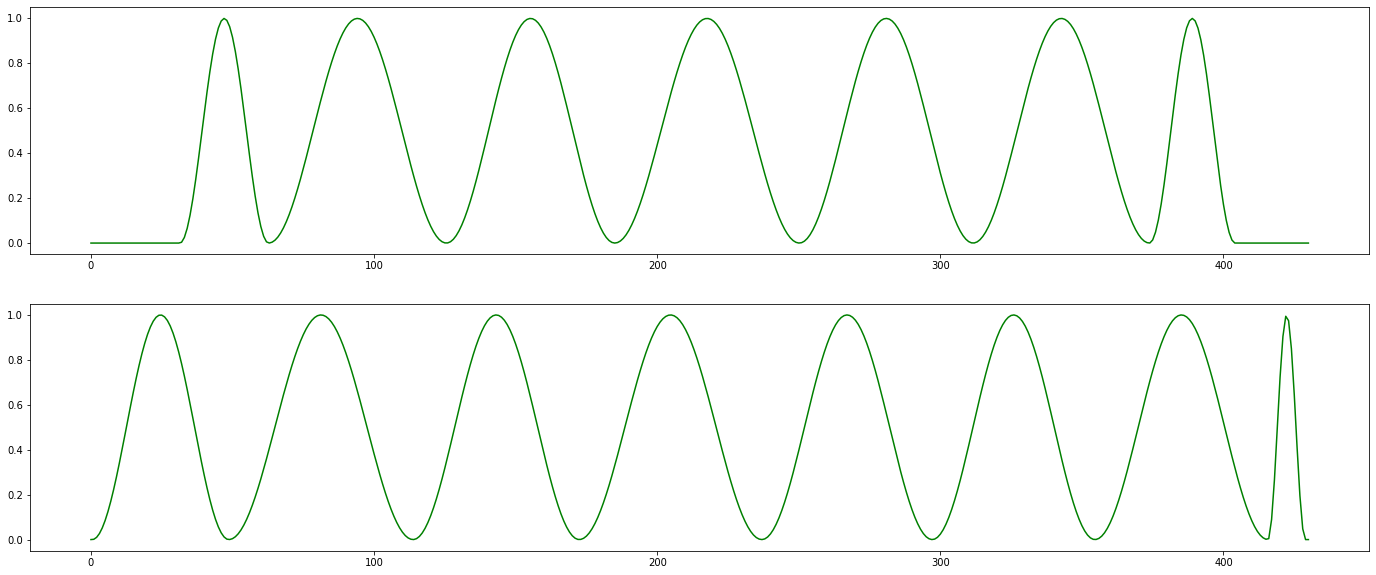

In [21]:
# Pick a record from the validation set to do the visualization

records_idLst = [testRecords_idLst[0]]
#records_idLst = [trainRecords_idLst[0]]

visualX_np, visualY_np = generateDataset(records_idLst)
visualN_cnt = visualX_np.shape[0]

(waveform_np, recordInfo_dict, recAnnotations_df) = loadData(records_idLst[0], False)

print("N:",recordInfo_dict['N'])
print("AT:",recordInfo_dict['AT'])

plt.figure(figsize=(24,10))
plt.subplot(211)
plt.plot(trainY_np[:visualN_cnt],'g')
plt.subplot(212)
plt.plot(visualY_np,'g')

Training Linear Regression:: 	0.306 s
Train R2:  0.43873	 Test R2: -2.22937	 (-5.08)
Train MAE:  0.22557	 Test MAE:  0.54828	 ( 2.43)


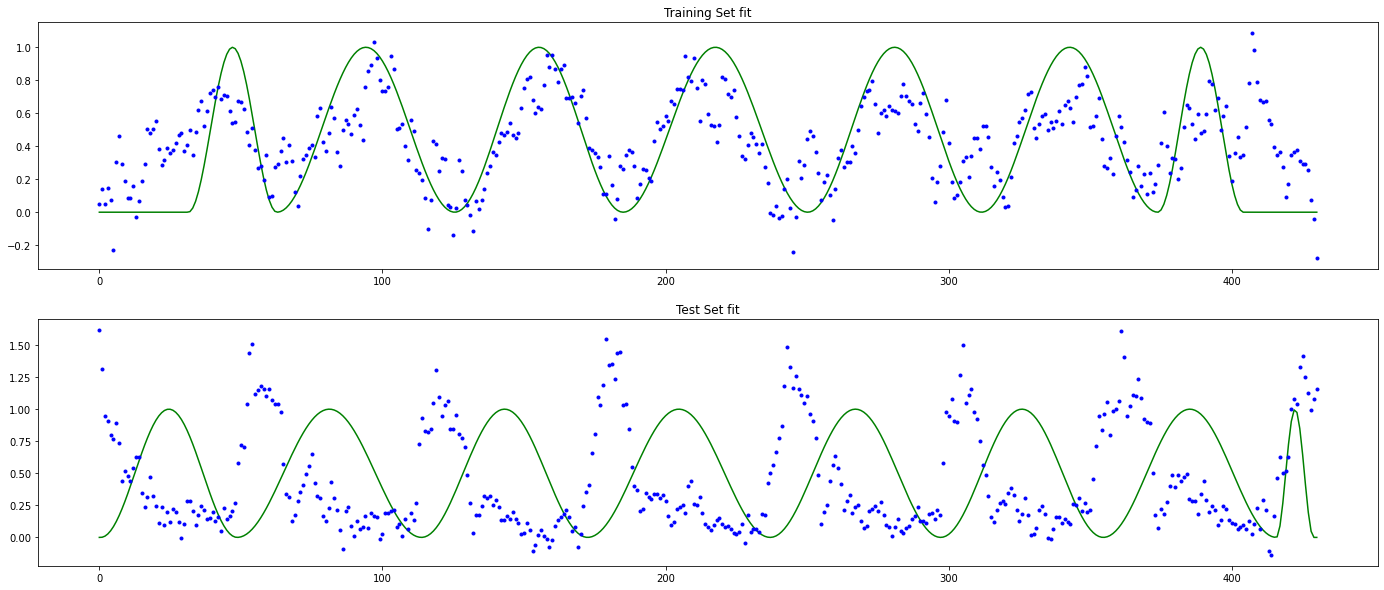

In [22]:
# Try Linear Regression

model = LinearRegression()

with Timer("Training Linear Regression:"):
    model.fit(trainX_np,trainY_np)

evaluateModel(model)

Training Decision Tree Regression:: 	2.037 s
Train R2:  1.00000	 Test R2: -1.32008	 (-1.32)
Train MAE:  0.00001	 Test MAE:  0.43121	 (63084.72)


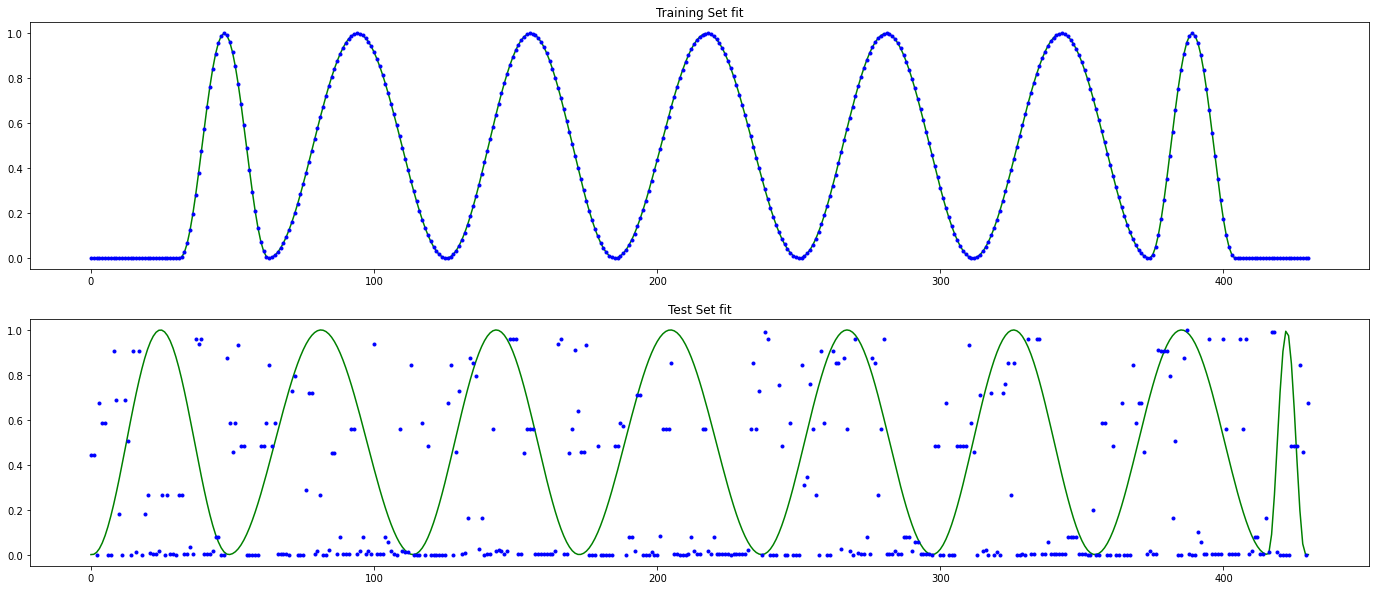

In [23]:
# Try Decision Tree Regression

from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(
    criterion = 'mse',
#    max_depth = 15,
)

with Timer("Training Decision Tree Regression:"):
    model.fit(trainX_np,trainY_np)


evaluateModel(model)

Training Random Forest Regression:: 	41.163 s
Train R2:  1.00000	 Test R2: -1.20749	 (-1.21)
Train MAE:  0.00001	 Test MAE:  0.42902	 (54608.81)


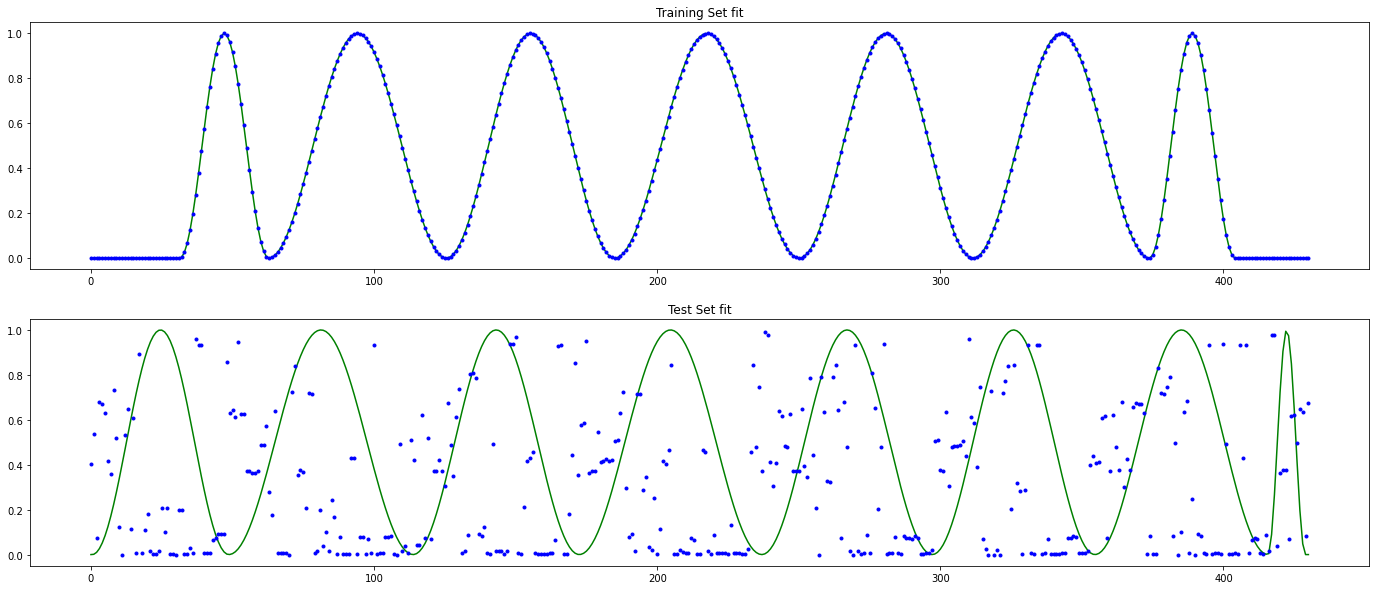

In [24]:
# Try Random Forest Regression

from sklearn.ensemble import RandomForestRegressor 

model = RandomForestRegressor(
    n_estimators = 30,
#    max_depth = 10,
#    min_samples_split = 100,   
#    random_state = 0,
) 

with Timer("Training Random Forest Regression:"):
    model.fit(trainX_np,trainY_np)

evaluateModel(model)

Training AdaBoost Regression:: 	53.047 s
Train R2:  0.57446	 Test R2: -0.70120	 (-1.22)
Train MAE:  0.19950	 Test MAE:  0.40549	 ( 2.03)


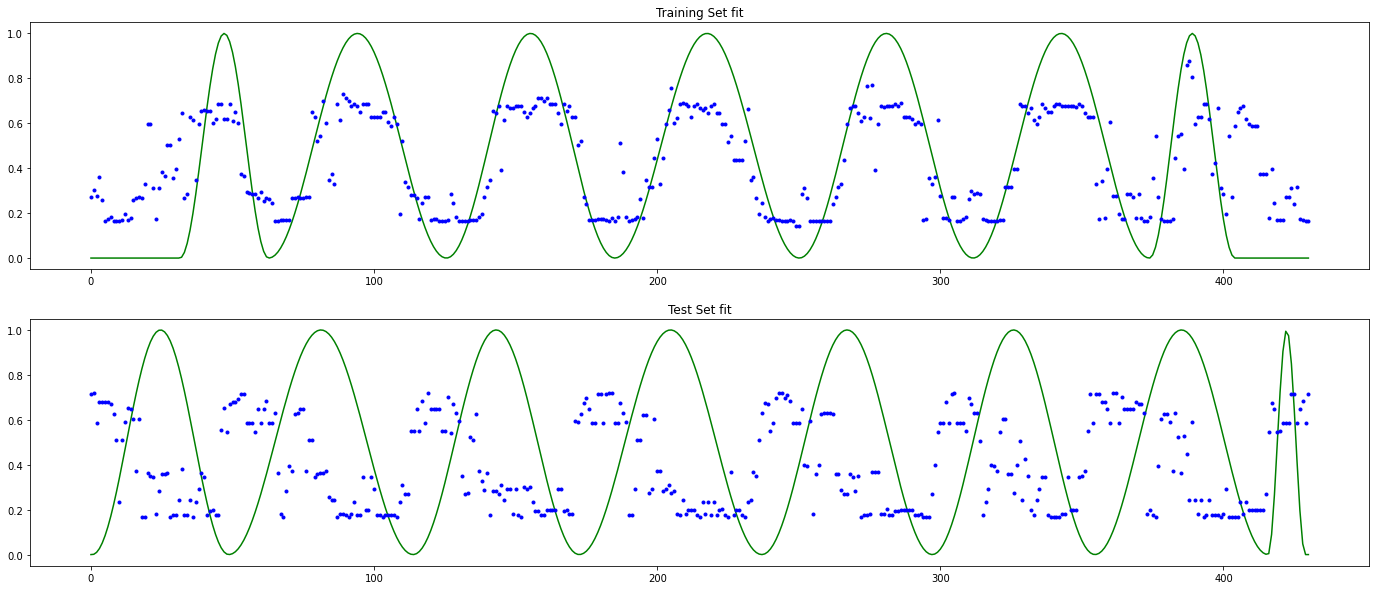

In [25]:
# Try AdaBoost Regression

from sklearn.ensemble import AdaBoostRegressor

model = AdaBoostRegressor(
#    n_estimators = 25,
    learning_rate = 0.10,
    loss = ['linear', 'square', 'exponential'][2],
) 

with Timer("Training AdaBoost Regression:"):
    model.fit(trainX_np,trainY_np)

evaluateModel(model)

Training Gradient Boost Regression:: 	77.329 s
Train R2:  0.67752	 Test R2: -0.86595	 (-1.28)
Train MAE:  0.12261	 Test MAE:  0.41447	 ( 3.38)


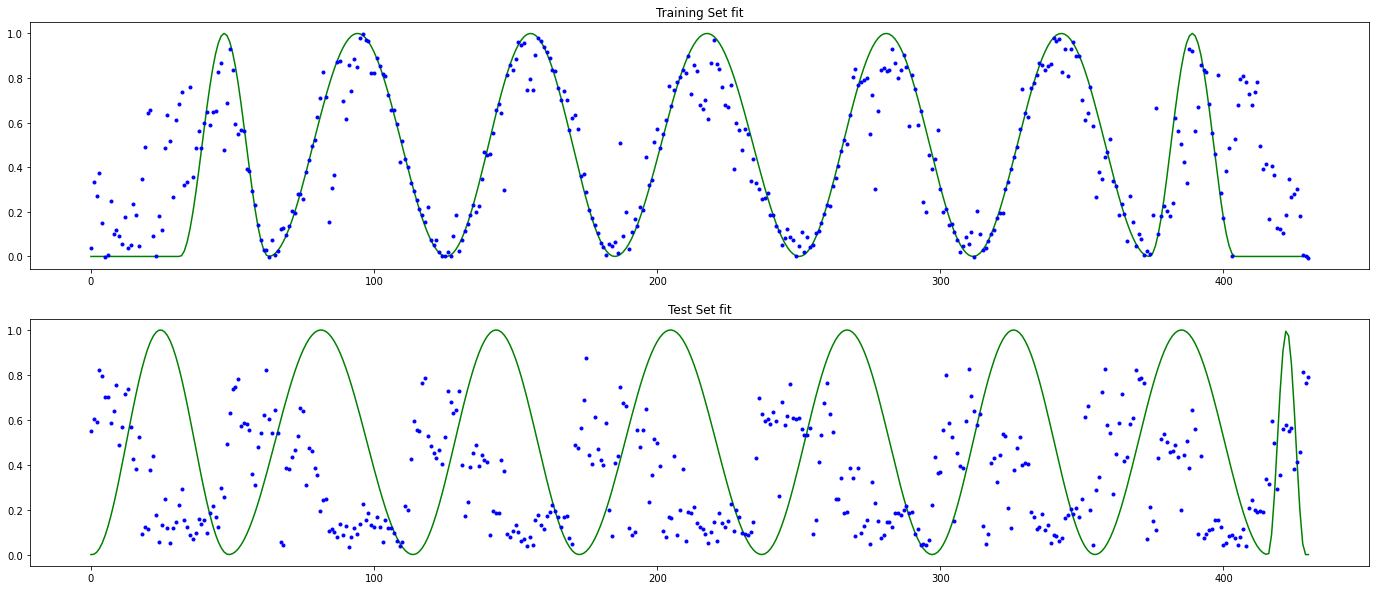

In [26]:
# Try Gradient Boost Regression

from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(
#    n_estimators = 25,
    learning_rate = 0.10,
    loss = ['ls', 'lad', 'huber', 'quantile'][1],
) 

with Timer("Training Gradient Boost Regression:"):
    model.fit(trainX_np,trainY_np)

evaluateModel(model)

Training Neural Network Regression:: 	13.949 s
Train Acc:  0.13457	 Test Acc:  0.00232	 ( 0.02)
Train MAE:  0.01051	 Test MAE:  0.52402	 (49.84)


Text(0.5, 1.0, 'Test Set fit')

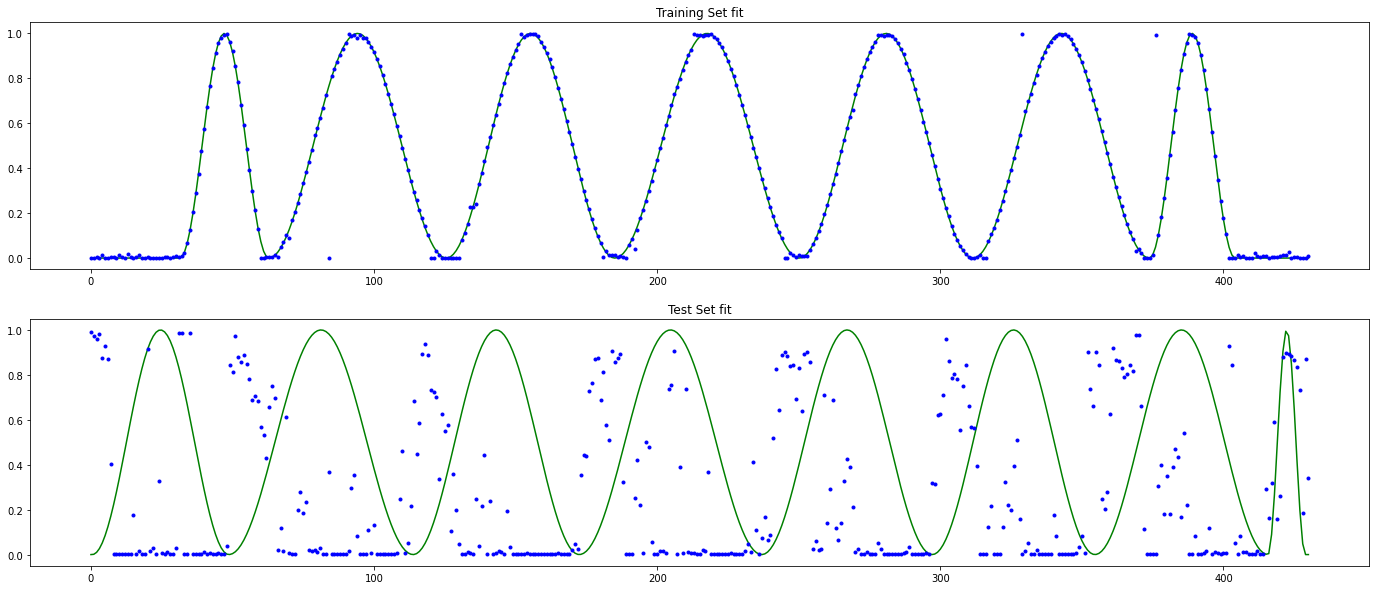

In [27]:
# Try out a Multilayer Neural Network

from keras import models
from keras.optimizers import Adam 
from keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# Parameters
batch_cnt = 1000
lRate_float = 0.01
validationFraction_f = 0.1
lossFunction_str = "sparse_categorical_crossentropy"
lossFunction_str = 'mean_squared_logarithmic_error'
lossFunction_str = "mean_squared_error"
lossFunction_str = 'mean_absolute_error'
metric_strList=['accuracy', 'mean_absolute_error']

# Derived
input_cnt = trainX_np.shape[1]
model = models.Sequential()

model.add(Dense(
    input_shape=[input_cnt],
#    units=int(input_cnt**(1.0/2)),
    units=input_cnt,
    activation='sigmoid',
))

model.add(Dense(
    input_shape=[input_cnt],
    units=int(input_cnt**(1.0/2)),
    activation='sigmoid',
))

model.add(Dense(
    units = 1,
    activation = 'sigmoid',
))

early_stopping = EarlyStopping(
    min_delta=1e-3, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

model.compile(
    Adam(lr=lRate_float), 
    loss=lossFunction_str,
    metrics=metric_strList,
)

# Derived

perm = np.random.permutation(trainX_np.shape[0])

with Timer("Training Neural Network Regression:"):
    model.fit(
        trainX_np[perm],
        trainY_np[perm],
        batch_size=batch_cnt,
        epochs=100,
        validation_split = validationFraction_f,
#        validation_data=(
#            validX_np, 
#            validY_np,
#        ),
        callbacks=[early_stopping],
        verbose=False,
    )

#testResult_np = neuralNet_model.predict(testX_np)
#score = neuralNet_model.score(testX_np, testY_np)
#score = neuralNet_model.evaluate(testX_np, testY_np)
#model.fit(trainX_np,trainY_np)


accuracy_idx = model.metrics_names.index('accuracy')
trainAcc_f = model.evaluate(trainX_np, trainY_np,verbose=False,)[accuracy_idx]
testAcc_f = model.evaluate(testX_np, testY_np,verbose=False,)[accuracy_idx]
print("Train Acc: %8.5f\t Test Acc: %8.5f\t (%5.2f)"%(trainAcc_f,testAcc_f,testAcc_f/trainAcc_f))

mae_idx = model.metrics_names.index('mean_absolute_error')
trainMAE_f = model.evaluate(trainX_np, trainY_np,verbose=False,)[mae_idx]
testMAE_f = model.evaluate(testX_np, testY_np,verbose=False,)[mae_idx]
print("Train MAE: %8.5f\t Test MAE: %8.5f\t (%5.2f)"%(trainMAE_f,testMAE_f,testMAE_f/trainMAE_f))

# Visualize the test performance
trainResult_np = model.predict(trainX_np)
visualResult_np = model.predict(visualX_np)

plt.figure(figsize=(24,10))

plt.subplot(211)
plt.plot(trainY_np[:visualN_cnt],'g')
plt.plot(trainResult_np[:visualN_cnt],'b.')
plt.title('Training Set fit')

plt.subplot(212)
plt.plot(visualY_np,'g')
plt.plot(visualResult_np,'b.')
plt.title('Test Set fit')